# DataFrame: Functional Chains for [TTrees](https://root.cern.ch/doc/master/classTTree.html) in Python.
<hr style="border-top-width: 4px; border-top-color: #359C38;">
The DataFrame class brings the feature called functional chains with caching to trees. This is achieved in identifying different functions are creating lists of transformations. 
Usability is a key. Functional chains are a lot simpler way of creating histograms because the user doesn't need to create loops. DataFrame will do it for you.

## Preparation
We include ROOT, DataFrame and PyTreeReader class. DataFrame uses PyTreeReader for filling histograms and filtering results. All of the computing is mostly done by using PyTreeReader inside the DataFrame Class. Clearly this will be done in a better way now that the usage of PyTreeReader in ROOT is still unknown. PyTreeReader can be found from https://github.com/dpiparo/pytreereader

In [1]:
import ROOT
from PyTreeReader import PyTreeReader
from fchains import DataFrame
from ROOT import TFile

Welcome to JupyROOT 6.07/07


This is to create a tree from test data called cernstaff.root

In [2]:
testFile = TFile('cernstaff.root')
testTree = testFile.Get('T')

Here we create the DataFrame object

In [3]:
dataFrame = DataFrame(testTree)

Creating the PyTreeReader


As you can see, it also creates a PyTreeReader. This is why PyTreeReader is mandatory for the class

## Traditional read without cache

In [4]:
%%time
dataFrame.filter(lambda e : e.Age() > 20).filter(lambda e : e.Children > 1).head(5)

|Category|Flag|Age|Service|Children|Grade|Step|Hrweek|Cost|Division|Nation|
|---|---|---|---|---|---|---|---|---|---|---|
|202|15|58|28|0|10|13|40|11975|P|D|
|530|15|63|33|0|9|13|40|10228|E|C|
|316|15|56|31|2|9|13|40|10730|P|F|
|361|15|61|35|0|9|7|40|9311|P|F|
|302|15|52|24|2|9|8|40|9966|P|D|


CPU times: user 107 ms, sys: 21.8 ms, total: 129 ms
Wall time: 126 ms


# Same but now first caching it and then rerunning the same

In [5]:
%%time
dataFrame.filter(lambda e : e.Age() > 20).filter(lambda e : e.Children > 1).cache().head(5)

|Category|Flag|Age|Service|Children|Grade|Step|Hrweek|Cost|Division|Nation|
|---|---|---|---|---|---|---|---|---|---|---|
|530|15|63|33|0|9|13|40|10228|E|C|
|316|15|56|31|2|9|13|40|10730|P|F|
|361|15|61|35|0|9|7|40|9311|P|F|
|302|15|52|24|2|9|8|40|9966|P|D|
|303|15|60|33|0|7|13|40|7599|P|I|


<function <lambda> at 0x7f7c24099de8>
NOT cached FILTER
<function <lambda> at 0x7f7c24099e60>
NOT cached FILTER
new cache = True
[<function <lambda> at 0x7f7c24099de8>, <function <lambda> at 0x7f7c24099e60>]
CPU times: user 48.7 ms, sys: 15.5 ms, total: 64.2 ms
Wall time: 68.5 ms


# Now rerunning it and using the cached results to print

In [6]:
%%time
dataFrame.filter(lambda e : e.Age() > 20).filter(lambda e : e.Children > 1).cache().head(5)

|Category|Flag|Age|Service|Children|Grade|Step|Hrweek|Cost|Division|Nation|
|---|---|---|---|---|---|---|---|---|---|---|
|302|15|53|25|1|9|9|40|9868|S|C|
|361|15|60|32|1|8|5|40|8012|P|I|
|340|15|51|28|0|8|13|40|8813|P|D|
|361|15|56|32|1|7|13|40|7850|P|F|
|361|15|51|29|0|7|13|40|7599|P|F|


<function <lambda> at 0x7f7c2ee8e398>
Cached FILTER
<function <lambda> at 0x7f7c289bc230>
Cached FILTER
new cache = False
CPU times: user 1.68 ms, sys: 1.41 ms, total: 3.09 ms
Wall time: 3.43 ms


There is some caching with the files in the Swan service, but the point is that first and second run differ alot with their speed

# Lets reset the cache by calling a function from the class

In [7]:
dataFrame.resetcache()

# Now we can demonstrate different histograms and drawing them

<function <lambda> at 0x7f7c24099de8>
NOT cached FILTER
new cache = True
[<function <lambda> at 0x7f7c24099de8>]
CPU times: user 100 ms, sys: 21.2 ms, total: 121 ms
Wall time: 126 ms


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


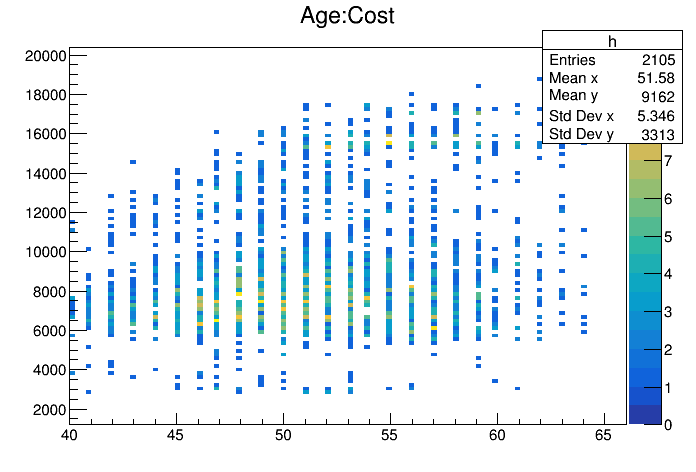

In [8]:
%%time
dataFrame.filter(lambda e : e.Age() > 45).cache().histo('Age:Cost').Draw('COLZ')
ROOT.gPad.Draw()

Rerun the same analysis, compare the time

<function <lambda> at 0x7f7c2ee8e398>
Cached FILTER
new cache = False
CPU times: user 24.5 ms, sys: 4.48 ms, total: 29 ms
Wall time: 25.1 ms


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


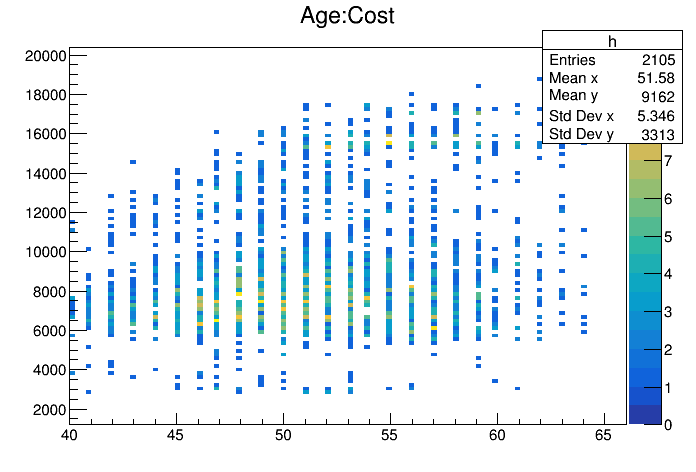

In [9]:
%%time
dataFrame.filter(lambda e : e.Age() > 45).cache().histo('Age:Cost').Draw('COLZ')
ROOT.gPad.Draw()

Lets add one more filter after the cache and see how it differs...

<function <lambda> at 0x7f7c14179aa0>
Cached FILTER
new cache = False
CPU times: user 21.4 ms, sys: 9.25 ms, total: 30.7 ms
Wall time: 26.1 ms


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


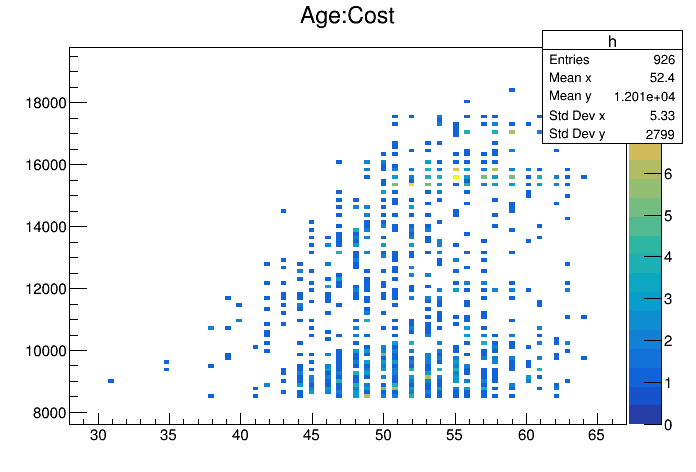

In [10]:
%%time
dataFrame.filter(lambda e : e.Age() > 45).cache().filter(lambda e: e.Cost() > 8500).histo('Age:Cost').Draw('COLZ')
ROOT.gPad.Draw()

## What can be done more?
This is the first implementation of the class and functional chains.

Usability can be improved with adding more and more transformations and actions to 

A lot can be achieved with seizable performance improvements with using the PyTreeReader.

However, there are some minor flaws in the class:
 - Reading more complex trees might need a different approach
 - If PyTreeReader is changed not to use brackets to handle the entries, this program crashes
 - Map() and FlatMap() functions have a skeleton ready, but it has to be figured out how and where new tree should be read to the PyTreeReader
 - TEntryList usage can be optimized more
 - This uses the RDD idea, so it uses the functions one by one, if there are 3 filters in a row it could run all these at the same time -> this way it doesnt have to go through the loop seperately for each of them.
 - Transformations after cache() are not working properly if there is more than 1 of them.
 - This Class is in Python and it should be converted to C++ when its possible

# Remember that this is a prototype, it will need optimizing and improvements